# Visualize Option Prices

In [143]:
%pip -q install ipympl

Note: you may need to restart the kernel to use updated packages.


In [144]:
%matplotlib ipympl

In [145]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings

sns.set_theme(style='darkgrid', palette='muted', font='monospace', font_scale=1.)
warnings.filterwarnings("ignore", message=".*constrained_layout not applied.*")


class OptionPrices:

    def __init__(self, ticker):
        self.ticker = ticker
        self.get_option_chains()
        self.get_options()

    def get_option_chains(self):
        asset = yf.Ticker(self.ticker)
        self.expirations = asset.options
        self.call_chain = {
            expiration: asset.option_chain(expiration).calls
            for expiration in self.expirations
        }
        self.put_chain = {
            expiration: asset.option_chain(expiration).puts
            for expiration in self.expirations
        }

    def get_options(self, price_estimate="avg"):
        self.calls = self.construct_option_matrix(
            self.call_chain,
            option_type="call",
            price_estimate=price_estimate
        )
        self.puts = self.construct_option_matrix(
            self.put_chain,
            option_type="put",
            price_estimate=price_estimate
        )

    def construct_option_matrix(self, option_chain, option_type, price_estimate):
        option_matrix = []
        for expiration, option_series in option_chain.items():
            options = pd.DataFrame(option_series["contractSymbol"])
            options["expirationDate"] = pd.to_datetime(expiration)
            options["strikePrice"] = option_series["strike"]

            if price_estimate == "avg":
                options["optionPrice"] = (option_series.bid + option_series.ask) / 2
            else:
                options["optionPrice"] = option_series.lastPrice

            if option_type == "call":
                options["profitPrice"] = options.strikePrice + options.optionPrice
            else:
                options["profitPrice"] = options.strikePrice - options.optionPrice

            option_matrix.append(options)
        return pd.concat(option_matrix, ignore_index=True)

    def plot_option_matrix(self, option_type, uniform_dates=True):
        option_matrix = self.calls if option_type == "calls" else self.puts

        fig = plt.figure(figsize=(12, 8), constrained_layout=True)
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(
            xs=option_matrix["strikePrice"],
            ys=mdates.date2num(option_matrix["expirationDate"]) if not uniform_dates
                else option_matrix["expirationDate"].map(lambda d: self.expirations.index(d.strftime("%Y-%m-%d"))),
            zs=option_matrix["optionPrice"],
        )

        if not uniform_dates:
            ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        else:
            ax.set_yticks(range(len(self.expirations)))
            ax.set_yticklabels(self.expirations)
        plt.yticks(rotation=45)

        ax.set_title(f"{self.ticker} {option_type} prices")
        ax.set_xlabel("strikePrice", labelpad=10)
        ax.set_ylabel("expirationDate", labelpad=30)
        ax.set_zlabel("optionPrice", labelpad=10)

        plt.show()


In [146]:
ticker = "TQQQ"
opt = OptionPrices(ticker)

In [147]:
opt.calls

,contractSymbol,expirationDate,strikePrice,optionPrice,profitPrice
0,TQQQ241227C00045000,2024-12-27,45.0,39.650,84.650
1,TQQQ241227C00050000,2024-12-27,50.0,34.650,84.650
2,TQQQ241227C00052000,2024-12-27,52.0,32.650,84.650
3,TQQQ241227C00055000,2024-12-27,55.0,29.650,84.650
4,TQQQ241227C00060000,2024-12-27,60.0,24.650,84.650
...,...,...,...,...,...
698,TQQQ270115C00110000,2027-01-15,110.0,18.500,128.500
699,TQQQ270115C00115000,2027-01-15,115.0,18.000,133.000
700,TQQQ270115C00120000,2027-01-15,120.0,16.000,136.000
701,TQQQ270115C00125000,2027-01-15,125.0,16.500,141.500


In [148]:
opt.puts

,contractSymbol,expirationDate,strikePrice,optionPrice,profitPrice
0,TQQQ241227P00045000,2024-12-27,45.0,0.015,44.985
1,TQQQ241227P00050000,2024-12-27,50.0,0.005,49.995
2,TQQQ241227P00051000,2024-12-27,51.0,0.015,50.985
3,TQQQ241227P00052000,2024-12-27,52.0,0.015,51.985
4,TQQQ241227P00053000,2024-12-27,53.0,0.005,52.995
...,...,...,...,...,...
671,TQQQ270115P00110000,2027-01-15,110.0,39.500,70.500
672,TQQQ270115P00115000,2027-01-15,115.0,43.000,72.000
673,TQQQ270115P00120000,2027-01-15,120.0,46.500,73.500
674,TQQQ270115P00125000,2027-01-15,125.0,50.000,75.000


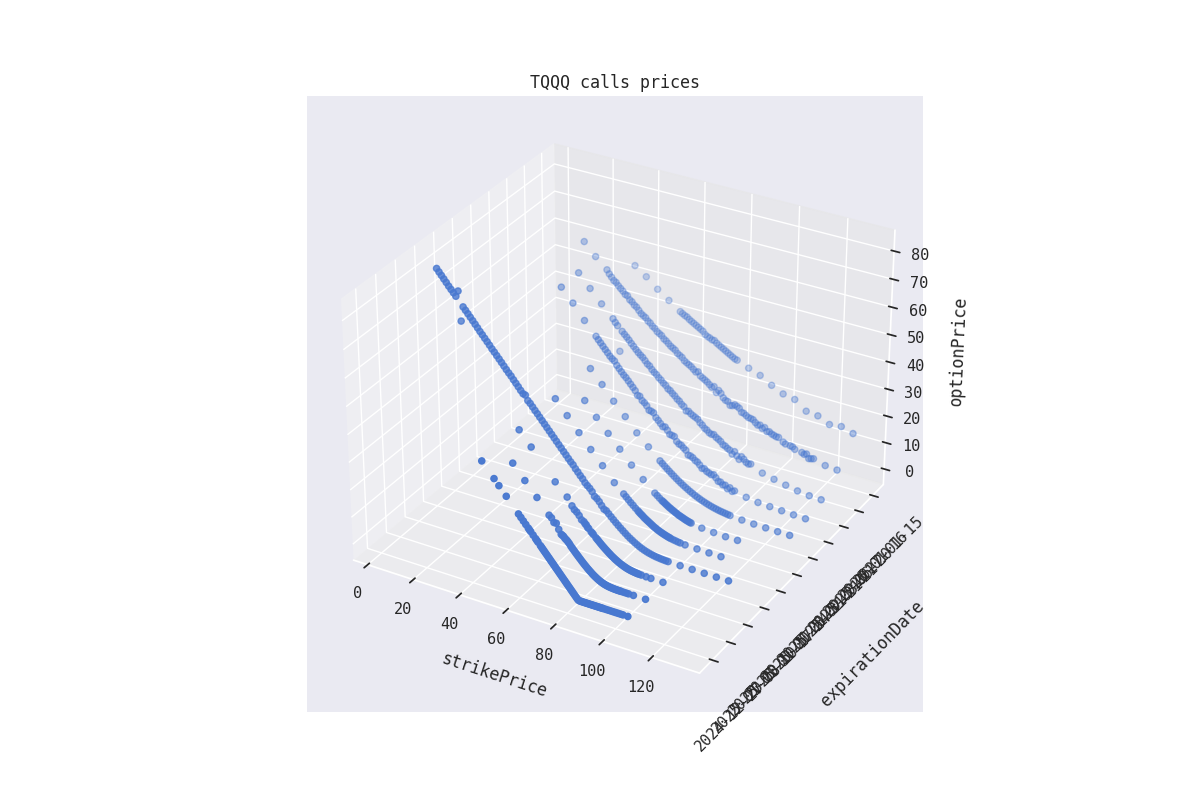

In [149]:
opt.plot_option_matrix("calls")

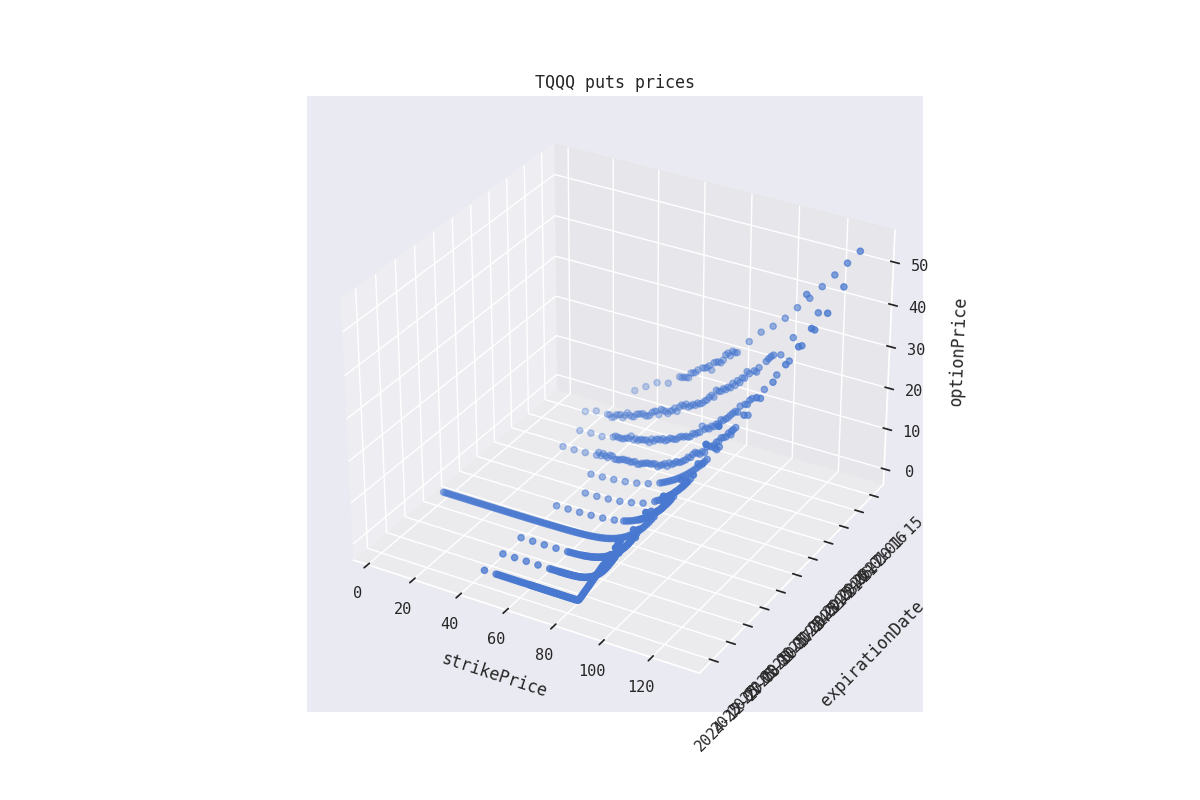

In [150]:
opt.plot_option_matrix("puts")